# 15. 도로 영역을 찾자! - 세그멘테이션 모델 만들기 [프로젝트]

|평가문항|상세기준|
|:---|:---|
|1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
|2. U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
|3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

## Step 1. KITTI 데이터셋 수집과 구축

다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [ ]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

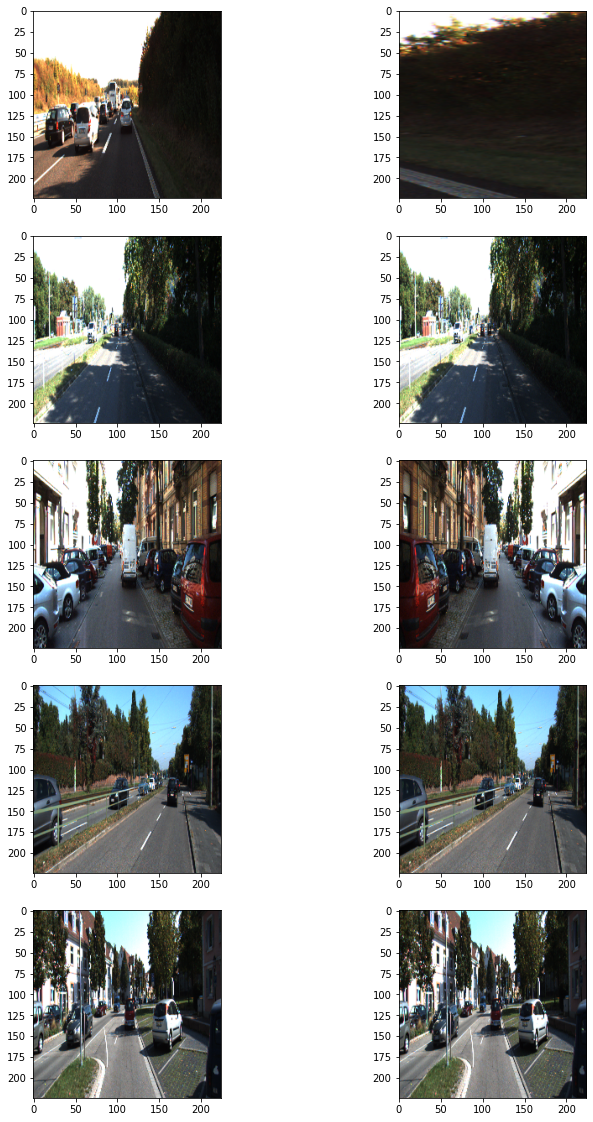

In [ ]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self,
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]

  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])

    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net, U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

In [ ]:
from keras import layers

def UNet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c1)
    p1 =layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(p1)
    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(p2)
    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c3)
    dr1 = layers.Dropout(0.4)(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)

    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(p3)
    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c4)
    dr2 = layers.Dropout(0.4)(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)

    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(p4)
    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(c5)

    up1 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(c5))
    merge1 = concatenate([dr2,up1], axis = 3)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(merge1)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c6)
    dr3 = layers.Dropout(0.4)(c6)

    up2 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(dr3))
    merge2 = concatenate([dr1,up2], axis = 3)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(merge2)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c7)
    dr4 = layers.Dropout(0.4)(c7)

    up3 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(dr4))
    merge3 = concatenate([c2,up3], axis = 3)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(merge3)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c8)
    dr5 = layers.Dropout(0.4)(c8)

    up4 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(dr5))
    merge4 = concatenate([c1,up4], axis = 3)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(merge4)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c9)

    c10 = layers.Conv2D(1, 1, activation = 'sigmoid')(c9)
    model = Model(inputs = inputs, outputs=[c10])
    return model

In [ ]:
model = UNet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_61[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_62[0][0]                  
____________________________________________________________________________________________

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history1 = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 10s 804ms/step - loss: 0.0058 - val_loss: 0.0162
Epoch 2/100
11/11 [==============================] - 9s 786ms/step - loss: 0.0095 - val_loss: 0.0154
Epoch 3/100
11/11 [==============================] - 9s 787ms/step - loss: 0.0075 - val_loss: 0.0190
Epoch 4/100
11/11 [==============================] - 9s 787ms/step - loss: 0.0069 - val_loss: 0.0149
Epoch 5/100
11/11 [==============================] - 9s 789ms/step - loss: 0.0068 - val_loss: 0.0170
Epoch 6/100
11/11 [==============================] - 9s 784ms/step - loss: 0.0067 - val_loss: 0.0137
Epoch 7/100
11/11 [==============================] - 9s 782ms/step - loss: 0.0083 - val_loss: 0.0142
Epoch 8/100
11/11 [==============================] - 9s 790ms/step - loss: 0.0105 - val_loss: 0.0140
Epoch 9/100
11/11 [==============================] - 9s 779ms/step - loss: 0.0080 - val_loss: 0.0158
Epoch 10/100
11/11 [==============================] - 9s 780ms/step - loss: 0.0071 - val_l

In [ ]:
#가중치 초기화를 적용한 UNET

def UNet_kernel_init(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(inputs)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1)
    p1 =layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p1)
    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p2)
    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c3)
    dr1 = layers.Dropout(0.4)(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)

    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p3)
    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c4)
    dr2 = layers.Dropout(0.4)(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)

    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p4)
    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c5)

    up1 = Conv2DTranspose(512, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(c5)
    merge1 = concatenate([dr2,up1], axis = 3)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge1)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c6)
    dr3 = layers.Dropout(0.4)(c6)

    up2 = Conv2DTranspose(256, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr3)
    merge2 = concatenate([dr1,up2], axis = 3)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge2)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c7)
    dr4 = layers.Dropout(0.4)(c7)

    up3 = Conv2DTranspose(128, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr4)
    merge3 = concatenate([c2,up3], axis = 3)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge3)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c8)
    dr5 = layers.Dropout(0.4)(c8)

    up4 = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr5)
    merge4 = concatenate([c1,up4], axis = 3)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge4)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c9)

    c10 = layers.Conv2D(1, 1, activation = 'sigmoid')(c9)
    model = Model(inputs = inputs, outputs=[c10])
    return model

In [ ]:
model2 = UNet_kernel_init()
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 224, 224, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_84[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_85[0][0]                  
____________________________________________________________________________________________

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_kernel_init.h5'

model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history2 = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 10s 803ms/step - loss: 0.0089 - val_loss: 0.0144
Epoch 2/100
11/11 [==============================] - 9s 775ms/step - loss: 0.0079 - val_loss: 0.0120
Epoch 3/100
11/11 [==============================] - 9s 781ms/step - loss: 0.0062 - val_loss: 0.0121
Epoch 4/100
11/11 [==============================] - 9s 782ms/step - loss: 0.0065 - val_loss: 0.0118
Epoch 5/100
11/11 [==============================] - 9s 780ms/step - loss: 0.0052 - val_loss: 0.0120
Epoch 6/100
11/11 [==============================] - 9s 780ms/step - loss: 0.0105 - val_loss: 0.0158
Epoch 7/100
11/11 [==============================] - 9s 778ms/step - loss: 0.0072 - val_loss: 0.0119
Epoch 8/100
11/11 [==============================] - 9s 776ms/step - loss: 0.0063 - val_loss: 0.0130
Epoch 9/100
11/11 [==============================] - 9s 776ms/step - loss: 0.0052 - val_loss: 0.0145
Epoch 10/100
11/11 [==============================] - 9s 777ms/step - loss: 0.0047 - val_l

U-Net++과 U-Net 차이점
1. Re-designed skip pathways : U-Net에서도 Skip-Connection을 해주는 부분이 있었지만, U-Net++에서는 DenseNet의 아이디어를 차용하여 Encoder(수축 경로)와 Decoder(확장 경로)사이의 Semantic(의미적) Gap을 연결시켜 줍니다.
2. Deep Supervision : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법입니다.

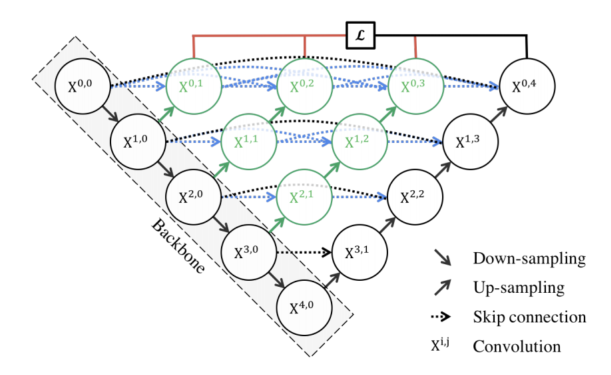

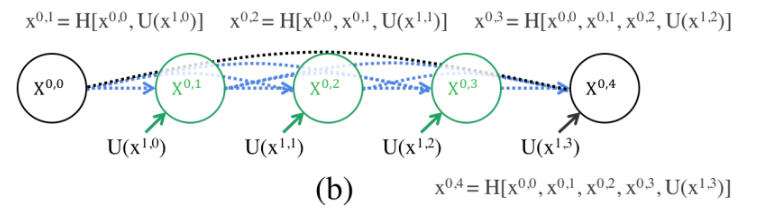

위 그림은 Feature map(이미지)이 첫 번째 Skip Pathway를 통과하는 것을 보여줍니다.  
기존 U-Net에서는 X0_0에서 X0_4로 가는 하나의 Skip만이 존재하였습니다. 그러나, U-Net++에서는 X0_0이 크기가 키워진(Upsampling) X1_0과 Concatenate되어 X0_1로 가는 것을 볼 수 있습니다. 그리고 이렇게 만들어진 X0_1은 또 다시 Upsampling된 X1_1과 Concatenate되어 X1_2로 흘려줍니다. 이런식으로 하면 저자들은 Encoder와 Decoder의 Feature map간의 Semantic Gap을 더 줄일 수 있게 된다고 언급합니다.  
그리고, Deep Supervision은 여러 Semantic Level(위 구조에서는 4개)은 각각 Feature map을 생성하여 정보를 가지고 있습니다. 따라서, 4개의 시맨틱 정보를 모두 이용하여 평균내어 결과를 예측하였습니다. Deep Supervision 방법은 선택적으로 적용할 수 있습니다.

In [ ]:
# UNET++

def UNet_plus_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    #backbone , Encoder(수축 경로)
    #conv0_0
    c0_0 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(inputs)
    c0_0 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_0)
    p0_0 =layers.MaxPooling2D(pool_size=(2, 2))(c0_0)

    #conv1_0
    c1_0 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p0_0)
    c1_0 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_0)
    p1_0 = layers.MaxPooling2D(pool_size=(2, 2))(c1_0)

    #conv2_0
    c2_0 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p1_0)
    c2_0 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c2_0)
    dr1 = layers.Dropout(0.4)(c2_0)
    p2_0 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)

    #conv3_0
    c3_0 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p2_0)
    c3_0 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c3_0)
    dr2 = layers.Dropout(0.4)(c3_0)
    p3_0 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)

    #conv4_0
    c4_0 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(p3_0)
    c4_0 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c4_0)



    #skip connection, Semantic(의미적) Gap
    #conv0_1
    c1_0up = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(c1_0))
    c0_1in = Concatenate()([c0_0, c1_0up])
    c0_1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_1in)
    c0_1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_1)

    #conv1_1
    c2_0up = UpSampling2D()(c2_0)
    c1_1in = Concatenate()([c1_0, c2_0up])
    c1_1 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_1in)
    c1_1 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_1)

    #conv2_1
    c3_0up = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c3_0))
    c2_1in = Concatenate()([c2_0, c3_0up])
    c2_1 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c2_1in)
    c2_1 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c2_1)

    #conv0_2
    c1_1up = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c1_1))
    c0_2in = Concatenate()([c0_0, c0_1,c1_1up])
    c0_2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_2in)
    c0_2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_2)

    #conv1_2
    c2_1up = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c2_1))
    c1_2in = Concatenate()([c1_0, c1_1,c2_1up])
    c1_2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_2in)
    c1_2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_2)

    #conv0_3
    c1_3up = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c1_2))
    c0_3in = Concatenate()([c0_0, c0_1,c0_2,c1_1up])
    c0_3 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_3in)
    c0_3 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_3)



    # Decoder(확장 경로)
    #conv3_1
    up3_1 = Conv2D(512, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c4_0))
    merge1 = concatenate([up3_1,c3_0])
    c3_1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge1)
    c3_1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c3_1)
    dr3 = layers.Dropout(0.4)(c3_1)

    #conv2_2
    up2_2 = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dr3))
    merge2 = concatenate([up2_2,c2_0,c2_1])
    c2_2 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge2)
    c2_2 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c2_2)
    dr4 = layers.Dropout(0.4)(c2_2)

    #conv1_3
    up1_3 = Conv2DTranspose(128, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr4)
    merge3 = concatenate([up1_3,c1_0,c1_1,c1_2])
    c1_3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge3)
    c1_3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_3)
    dr5 = layers.Dropout(0.4)(c1_3)

    #conv0_4
    up0_4 = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr5)
    merge4 = concatenate([up0_4,c0_0,c0_1,c0_2,c0_3])
    c0_4 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge4)
    c0_4 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c0_4)

    #output
    output = layers.Conv2D(1, 1, activation = 'sigmoid')(c0_4)
    model = Model(inputs = inputs, outputs=[output])
    return model

In [ ]:
model3 = UNet_plus_plus()
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_179 (Conv2D)             (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_179[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_180[0][0]                 
____________________________________________________________________________________________

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus.h5'

model.compile(optimizer = Adam(1e-4), loss = dice_coef_loss)
history3 = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 10s 792ms/step - loss: 0.1165 - val_loss: 0.1437
Epoch 2/100
11/11 [==============================] - 8s 773ms/step - loss: 0.0683 - val_loss: 0.1446
Epoch 3/100
11/11 [==============================] - 9s 779ms/step - loss: 0.0702 - val_loss: 0.1574
Epoch 4/100
11/11 [==============================] - 9s 783ms/step - loss: 0.0649 - val_loss: 0.1788
Epoch 5/100
11/11 [==============================] - 9s 781ms/step - loss: 0.1507 - val_loss: 0.2289
Epoch 6/100
11/11 [==============================] - 9s 776ms/step - loss: 0.1380 - val_loss: 0.1928
Epoch 7/100
11/11 [==============================] - 9s 775ms/step - loss: 0.1047 - val_loss: 0.1481
Epoch 8/100
11/11 [==============================] - 9s 776ms/step - loss: 0.2891 - val_loss: 0.1627
Epoch 9/100
11/11 [==============================] - 8s 773ms/step - loss: 0.1437 - val_loss: 0.1521
Epoch 10/100
11/11 [==============================] - 8s 773ms/step - loss: 0.1910 - val_l

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

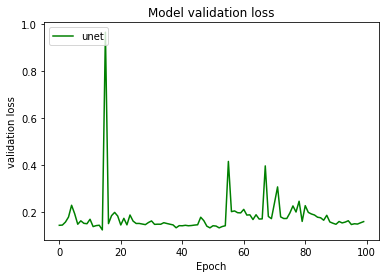

In [ ]:
#훈련 과정을 시각화
plt.plot(history3.history['val_loss'], 'g')
plt.title('Model validation loss')
plt.ylabel('validation loss')
plt.xlabel('Epoch')
plt.legend(['unet', 'UNet_kernel_init','unet_plus_plus'], loc='upper left')
plt.show()

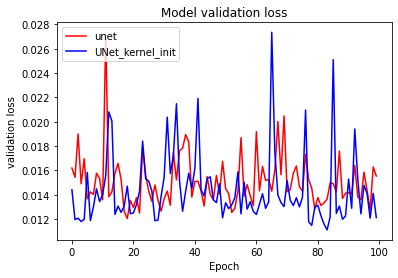

In [ ]:
plt.plot(history1.history['val_loss'], 'r')
plt.plot(history2.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('validation loss')
plt.xlabel('Epoch')
plt.legend(['unet', 'UNet_kernel_init','unet_plus_plus'], loc='upper left')
plt.show()

모델별 iou

In [ ]:
model_path1 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
model_path2 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_kernel_init.h5'
model_path3 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus.h5'


model = tf.keras.models.load_model(model_path1)
model2 = tf.keras.models.load_model(model_path2)
model3 = tf.keras.models.load_model(model_path3, custom_objects={'dice_coef_loss': dice_coef_loss})

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum() # intersection
    union = np.logical_or(target, prediction).sum() # Union
    iou_score = float(intersection) / float(union) # iou 스코어
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.4).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!

    if label_path:
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

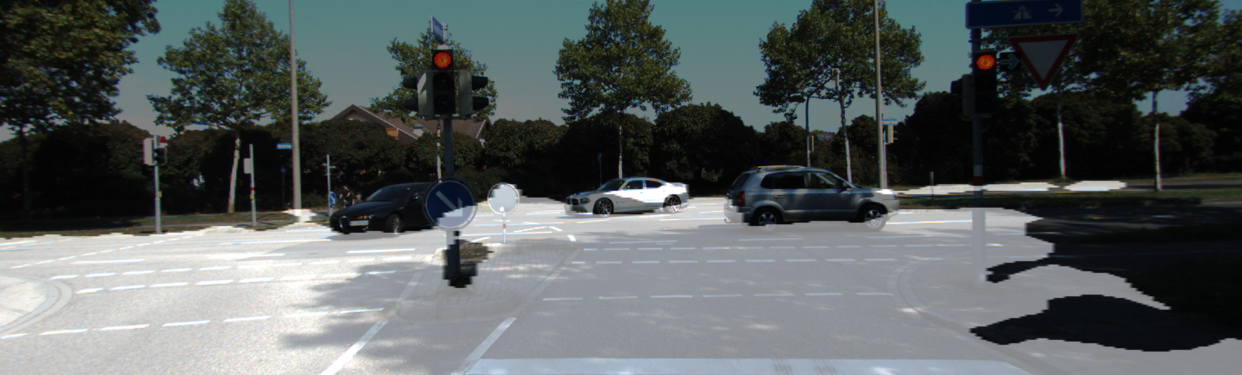

IoU : 0.736631


0.736631157050944

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

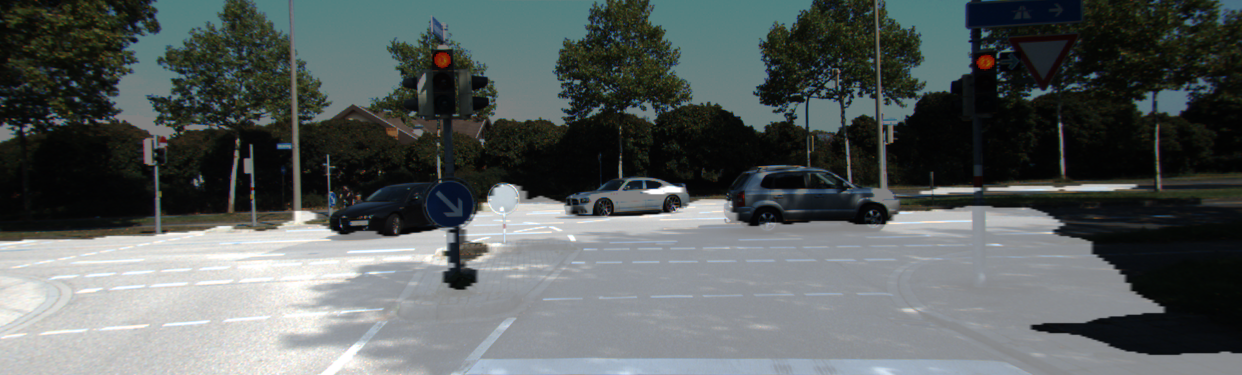

IoU : 0.727707


0.727706841067165

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model2,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

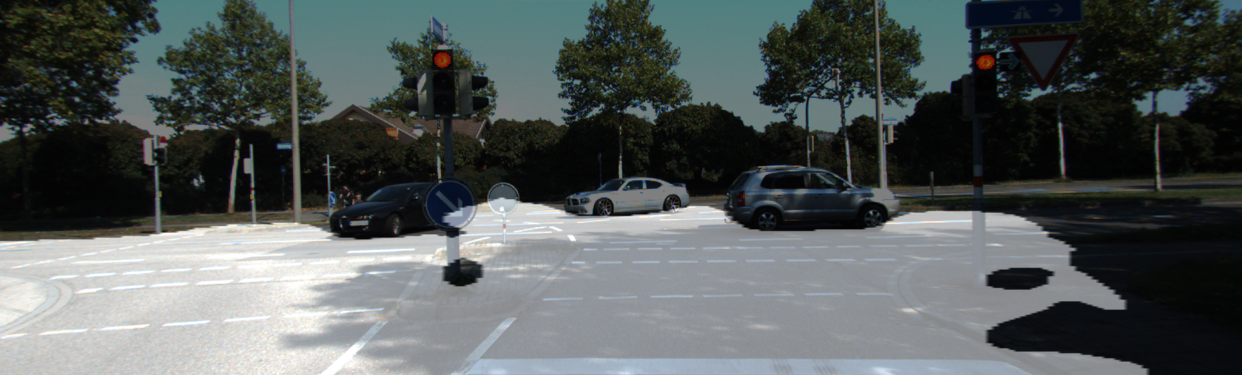

IoU : 0.762436


0.7624355348527699

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model3,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

Unet++ 구조를 만들어보면서 중간부분을 연결하는 과정에서 한두개씩  conv2d 레이러를 잘못 연결해서 어느 에포크순간에 튀는 현상이 발생했었다. 그래서 Unet++를 많이 수정했었다.  
unet과 unet++의 로스를 비교했을 때, unet 로스가 10배가량 작게 나왔는데 이건 loss를 다르게 사용해서 그런것 같다. unet은 binary crossentropy를 사용했고, unet++는 dice_coff_loss를 사용했다. 이 차이로 인하여 로스값이 다르게 나오는것 같다.  
이미지를 불러와 결과를 살펴보고 iou를 계산해봤는데, 이미지로 봤을 땐 unet++가 segmentation 부분이 좀더 곡선형태로 부드럽게 표현되었다. 사진 한개로 iou를 비교해봤을 땐 unet++가 unet보다 성능이 좋게 나왔다.